_This notebook contains code and comments from Section 6.5 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

## 6.5 Case Study: Document Retrieval
Document retrieval is the task of retrieving documents from a database to match a user’s query. For example, a paralegal at a law firm might need to search for information about previous cases from legal archives in order to establish precedent and research case law. Or perhaps a graduate student might need to search for articles from a journal’s database during the course of a literature survey of work in a specific area. 

In this case study, the problem is set up as a 3-class classification problem of identifying the relevance rank/class (least, moderately or highly relevant) given a query-document pair. We explore the performance of different LightGBM classifiers for this task. 

### 5.5.1	The LETOR Data Set
The data set we will use for this case study is called the LEarning TO Rank (LETOR) ver. 4.0, which was itself created from a large corpus of webpages called GOV2. The [GOV2 data set](http://ir.dcs.gla.ac.uk/test_collections/access_to_data.html) is a collection of about 25 million webpages extracted from the .gov domain.

The LETOR 4.0  data collection is derived from the GOV2 corpus and is made freely available by Microsoft Research. The collection contains several data sets, and we will use the data set that was originally developed for the Million Query track of the 2008 Text Retrieval Conference (TREC), specifically, [MQ2008.rar](https://www.microsoft.com/en-us/research/project/letor-learning-rank-information-retrieval/#!letor-4-0). 

In [1]:
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import numpy as np

# Load the data
query_data_file = './data/ch05/MQ2008/Querylevelnorm.txt'
X, y = load_svmlight_file(query_data_file)

# Split into train and test sets
Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, test_size=0.2, random_state=42)

### 6.5.1 Document Retrieval with XGBoost

In [2]:
# # Get results of the LightGBM runs
# cv_scores = {'rf': 0.8051450187962624, 'gbdt': 0.8122129268166652, 'goss': 0.8131167212266558, 'dart': 0.8155001366110529}
# tst_scores = {'rf': 0.8034834045349983, 'gbdt': 0.8120276043378245, 'goss': 0.8139993427538613, 'dart': 0.8245152809727243}
# run_time = {'rf': 122.31625509262085, 'gbdt': 23.24663543701172, 'goss': 19.403377532958984, 'dart': 1144.2085926532745}
import pickle
with open('./data/LightGBMMetrics.pickle', 'rb') as handle:
    metrics = pickle.load(handle)
print(metrics)

{'cv_scores': {'RF': 0.7931469208814301, 'GBDT': 0.8119661826008515, 'GOSS': 0.812212690406932, 'DART': 0.8178834169041739}, 'tst_scores': {'RF': 0.7982254354255669, 'GBDT': 0.8153138350312192, 'GOSS': 0.8136707196845219, 'DART': 0.8189286887939533}, 'run_times': {'RF': 114.08808469772339, 'GBDT': 19.71247959136963, 'GOSS': 22.5469913482666, 'DART': 1063.1322021484375}}


In [3]:
from xgboost import DMatrix, XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import time

In [4]:
from scipy.stats import randint, uniform
xgb_params = {'max_depth': randint(2, 10), 
              'learning_rate': 2**np.linspace(-6, 2, num=5),
              'min_child_weight': [1e-2, 1e-1, 1, 1e1, 1e2],
              'colsample_bytree': uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 10, 100],
              'reg_lambda': [0, 1e-1, 1, 10, 100]}

In [5]:
start = time.time()
xgb = XGBClassifier(booster='gbtree', objective='multi:softmax', eval_metric='merror', use_label_encoder=False, n_jobs=-1)
num_random_iters = 20
num_cv_folds = 5
cv = RandomizedSearchCV(estimator=xgb, 
                        param_distributions=xgb_params,
                        n_iter=num_random_iters,
                        cv=num_cv_folds,  
                        refit=True,
                        random_state=42, verbose=1)
cv.fit(Xtrn, ytrn, eval_set=[(Xtst, ytst)], verbose=False)
metrics['run_times']['XGB'] = time.time() - start

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [6]:
print('XGBoost: Best score: {0}, best params: {1} '.format(cv.best_score_, cv.best_params_))
metrics['cv_scores']['XGB'] = cv.best_score_

ypred = cv.best_estimator_.predict(Xtst)
metrics['tst_scores']['XGB'] = accuracy_score(ytst, ypred)

XGBoost: Best score: 0.8157463066889432, best params: {'colsample_bytree': 0.4936111842654619, 'learning_rate': 0.25, 'max_depth': 8, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 100} 


In [7]:
# scores = np.c_[np.array(list(metrics['cv_scores'].values())), np.array(list(metrics['tst_scores'].values()))]
print(metrics)
with open('./data/XGBoostMetrics.pickle', 'wb') as handle:
    pickle.dump(metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)

{'cv_scores': {'RF': 0.7931469208814301, 'GBDT': 0.8119661826008515, 'GOSS': 0.812212690406932, 'DART': 0.8178834169041739, 'XGB': 0.8157463066889432}, 'tst_scores': {'RF': 0.7982254354255669, 'GBDT': 0.8153138350312192, 'GOSS': 0.8136707196845219, 'DART': 0.8189286887939533, 'XGB': 0.8186000657246139}, 'run_times': {'RF': 114.08808469772339, 'GBDT': 19.71247959136963, 'GOSS': 22.5469913482666, 'DART': 1063.1322021484375, 'XGB': 193.24053812026978}}


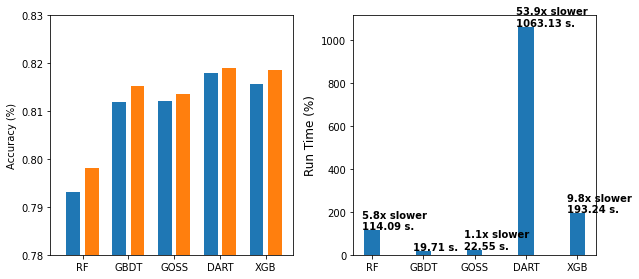

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

scores = np.array(list(metrics['cv_scores'].values()))
ax[0].bar(np.arange(1, 6)-0.2, scores, width=0.3)
scores = np.array(list(metrics['tst_scores'].values()))
ax[0].bar(np.arange(1, 6)+0.2, scores, width=0.3)
ax[0].axis([0.3, 5.6, 0.78, 0.83])
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_xticks([1, 2, 3, 4, 5]);
ax[0].set_xticklabels(['RF', 'GBDT', 'GOSS', 'DART', 'XGB']);

times = np.array(list(metrics['run_times'].values()))
times_scaled = times / np.min(times)
ax[1].bar(np.arange(1, 6), times, width=0.3)
# for i, v in enumerate(times_scaled):
#     ax[1].text(i + 0.8, times[i] + 3.5, '{0:3.2f}%\n{1:4.2f} s.'.format(v, times[i]), fontweight='bold')
for i, v in enumerate(times_scaled):
    if i == 1:
        ax[1].text(i + 0.8, times[i] + 3.5, '\n{1:4.2f} s.'.format(v, times[i]), fontweight='bold')
    else:
        ax[1].text(i + 0.8, times[i] + 3.5, '{0:3.1f}x slower\n{1:4.2f} s.'.format(v, times[i]), fontweight='bold')


ax[1].set_ylabel('Run Time (%)', fontsize=12)
ax[1].set_xticks([1, 2, 3, 4, 5]);
ax[1].set_xticklabels(['RF', 'GBDT', 'GOSS', 'DART', 'XGB'])


fig.tight_layout()
plt.savefig('./figures/CH06_F16_Kunapuli.png', format='png', dpi=300, bbox_inches='tight')
plt.savefig('./figures/CH06_F16_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight')